# Проект: Обучение с учителем: качество модели

## Описание проекта

в интернет-магазин «В один клик» активность покупателей начала снижаться, разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

### Описание данных

фаил market_file.csv содержит:

    id — номер покупателя в корпоративной базе данных.
    Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
    Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
    Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
    Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
    Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
    Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
    Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
    Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
    Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
    Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
    Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
    Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.


фаил market_money.csv содержит:

    id — номер покупателя в корпоративной базе данных.
    Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
    Выручка — сумма выручки за период.
    
фаил market_time.csv содержит:

    id — номер покупателя в корпоративной базе данных.
    Период — название периода, во время которого зафиксировано общее время.
    минут — значение времени, проведённого на сайте, в минутах.
    
фаил money.csv содержит:

    id — номер покупателя в корпоративной базе данных.
    Прибыль — значение прибыли.

## Шаг 1. 

### Загрузка данных

In [1]:
!pip install scikit-learn==1.4.2
!pip install matplotlib==3.5.0 -q

In [2]:
import pandas as pd
import sklearn
!pip install phik -q

import matplotlib.pyplot as plt
import phik
!pip install shap -q
# !pip install shap --upgrade
import shap
import seaborn as sns
# загружаем нужные классы
# класс ColumnTransformer помогает работать с данными разного типа в одном наборе
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# дополнительные классы для преобразования данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler,MinMaxScaler,PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
# класс для работы с пропусками
from sklearn.impute import SimpleImputer 
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif


In [3]:
# откроем фаил /datasets/market_file.csv , market_money.csv, market_time.csv, money.csv
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv',sep=',')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv', sep =';' , decimal=',')

### Проверьте, что данные в таблицах соответствуют описанию.

In [4]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


описания файла совпадает с файлом 

In [5]:
# посмотрим на данные 
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

все данные соответствуют пропусков нет

In [6]:
market_file.duplicated().sum()

0

в файле не содержатся явных дубликатов

In [7]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


описания файла совпадает с файлом

In [8]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


все данные соответствуют пропусков нет

In [9]:
market_money.duplicated().sum()

0

в файле не содержатся явных дубликатов

In [10]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


описания файла совпадает с файлом

In [11]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


все данные соответствуют пропусков нет

In [12]:
market_time.duplicated().sum()

0

в файле не содержатся явных дубликатов

In [13]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


описания файла совпадает с файлом

In [14]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


все данные соответствуют пропусков нет

In [15]:
money.duplicated().sum()

0

в файле не содержатся явных дубликатов

## Шаг 2. Исследовательский анализ данных

In [16]:
# выведем тех пользователей которые хоть раз не активничали за 3 месяца
mar =market_money.query('Выручка==0')['id'] 
mar

0     215348
2     215348
28    215357
29    215357
34    215359
35    215359
Name: id, dtype: int64

всего 3 пользователей у которых не было не какой активности в одном из месяцев
удалим их из всех файлом для дальнейшего анализа 

In [17]:
market_money = market_money.loc[~market_money['id'].isin(mar)]
market_money.query('Выручка==0')['id'] 

Series([], Name: id, dtype: int64)

In [18]:
market_money['Период'].value_counts()

предыдущий_месяц       1297
текущий_месяц          1297
препредыдущий_месяц    1297
Name: Период, dtype: int64

удалили из файла не нужные строки и проверили

### иследование - market_time

In [19]:
market_file = market_file.loc[~market_file['id'].isin(mar)]
market_time = market_time.loc[~market_time['id'].isin(mar)]
money = money.loc[~money['id'].isin(mar)]

In [20]:
market_time['Период'].value_counts()

предыдцщий_месяц    1297
текущий_месяц       1297
Name: Период, dtype: int64

In [21]:
def f(data):
    if data['Период']=='предыдцщий_месяц':
        return 'предыдущий_месяц'
    return data['Период']
market_time['Период'] = market_time.apply(f , axis=1)
market_time.head(2)

,id,Период,минут
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12


мы нашли пользователей с активностью не менее трёх месяцев, удалили их из всех файла в для дальнейшего анализа, то есть оставили тех которые что-либо покупали в этот период.

<AxesSubplot:ylabel='Период'>

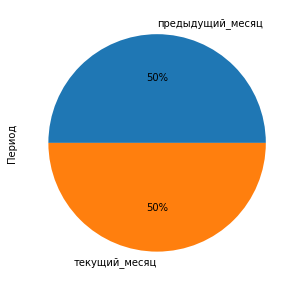

In [22]:
market_time['Период'].value_counts().plot( kind = 'pie', autopct = '%1.0f%%', figsize=(5,5))

распределение в периоде хорошие на каждый участки ровны

In [23]:
market_time['минут'].describe()

count    2594.000000
mean       13.340401
std         4.081999
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64

Text(0.5, 1.0, 'тратта пользователем времени на сайте')

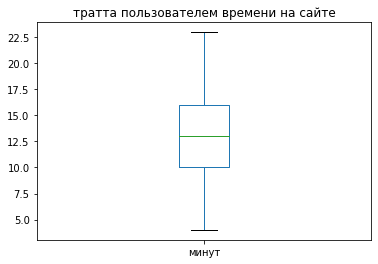

In [24]:

market_time['минут'].plot(kind='box')
plt.title('тратта пользователем времени на сайте')

медиана пребывания за все время составила 13 минут средние время пребывания 13.34 минуты минимальное время 4 минуты и максимальное 23 минуты 

Text(0.5, 1.0, 'тратта пользователем времени на сайте')

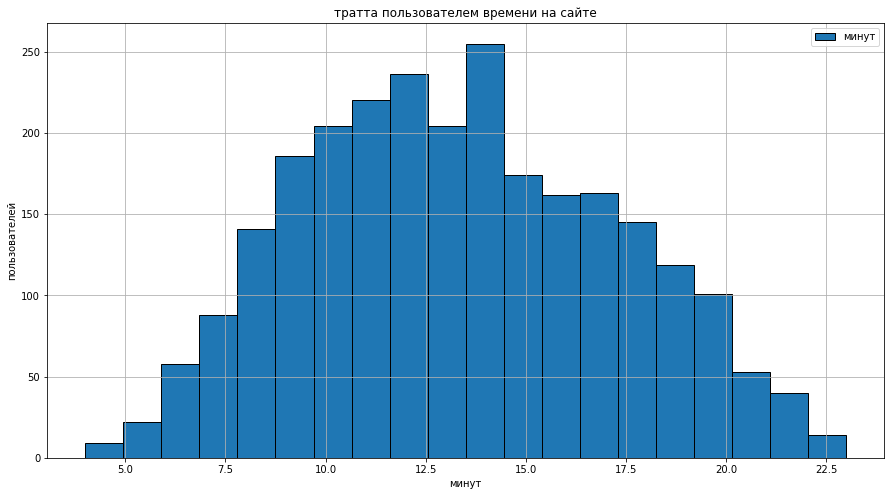

In [25]:
market_time['минут'].hist(bins=20 ,  figsize=(15, 8), ec='black', legend=True)
plt.xlabel('минут')
plt.ylabel('пользователей')
plt.title('тратта пользователем времени на сайте')

на диаграмме видно что не много смещенное в левов виде колокола, на графике с усиками не видно выбросов тоже все хорошо

In [26]:
#посмотрим на данные текущего месяца 
market_time[market_time['Период']=='текущий_месяц'].describe()

,id,минут
count,1297.000000,1297.000000
mean,215998.986893,13.211257
std,374.578554,4.220222
min,215349.000000,4.000000
25%,215675.000000,10.000000
50%,215999.000000,13.000000
75%,216323.000000,16.000000
max,216647.000000,23.000000


Text(0.5, 1.0, 'тратта пользователем времени на сайте')

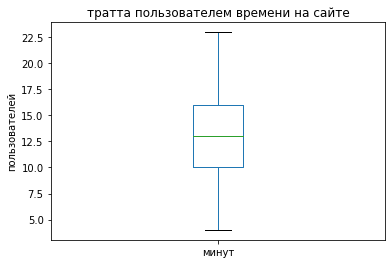

In [27]:
market_time[market_time['Период']=='текущий_месяц']['минут'].plot(kind='box')
plt.ylabel('пользователей')
plt.title('тратта пользователем времени на сайте')

за текущий месяц медиана по время такая же 13 минут средние чуть меньше и составило 13.21 минимальное и максимальное такое же как и за все время

Text(0.5, 1.0, 'тратта пользователем времени на сайте')

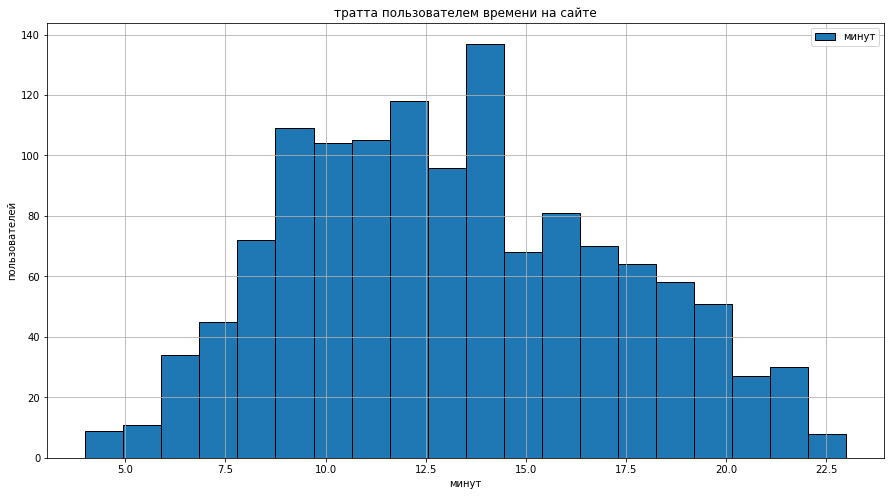

In [28]:
market_time[market_time['Период']=='текущий_месяц']['минут'].hist(bins=20 ,  figsize=(15, 8), ec='black', legend=True)
plt.xlabel('минут')
plt.ylabel('пользователей')
plt.title('тратта пользователем времени на сайте')

на диаграмме видно что не много смещенное в левов виде колокола, на графике с усиками не видно выбросов тоже все хорошо

In [29]:
# посмотрим на данные прошлого месеца 
market_time[market_time['Период']!='текущий_месяц'].describe()

,id,минут
count,1297.000000,1297.000000
mean,215998.986893,13.469545
std,374.578554,3.936323
min,215349.000000,5.000000
25%,215675.000000,11.000000
50%,215999.000000,13.000000
75%,216323.000000,17.000000
max,216647.000000,23.000000


Text(0.5, 1.0, 'тратта пользователем времени на сайте')

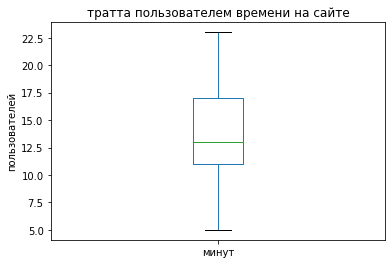

In [30]:
market_time[market_time['Период']!='текущий_месяц']['минут'].plot(kind='box')
plt.ylabel('пользователей')
plt.title('тратта пользователем времени на сайте')

за прошлый месяц медиана по время такая же 13 минут средние чуть больше и составило 13.47 минимальное стала выше 5 минут и максимальное такое же как и за все время

Text(0.5, 1.0, 'тратта пользователем времени на сайте')

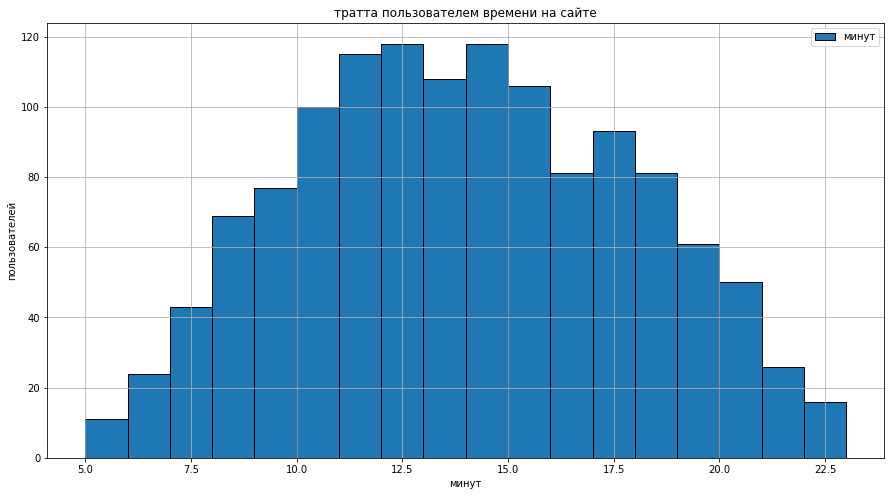

In [31]:
market_time[market_time['Период']!='текущий_месяц']['минут'].hist(bins=18 ,  figsize=(15, 8), ec='black', legend=True)
plt.xlabel('минут')
plt.ylabel('пользователей')
plt.title('тратта пользователем времени на сайте')

на диаграмме все хорошо и распределение виде колокола, на графике с усиками не видно выбросов тоже все хорошо

### иследование - market_file

In [32]:
market_file.head(2)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5


In [33]:
market_file['Длительность'] = market_file['Длительность'] / 60
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
1,215349,Снизилась,премиум,да,4.4,4,13.650000,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,8.983333,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,14.933333,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,17.733333,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,12.700000,0.26,Домашний текстиль,4,1,1,4


In [34]:
market_file.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000
mean,215998.986893,4.254433,4.009252,10.049897,0.320547,3.267540,2.841172,4.184271,8.186584
std,374.578554,1.015618,0.696048,4.151691,0.249657,1.354623,1.973451,1.950973,3.977061
min,215349.000000,0.900000,3.000000,2.016667,0.110000,1.000000,0.000000,0.000000,1.000000
25%,215675.000000,3.700000,4.000000,6.833333,0.170000,2.000000,1.000000,3.000000,5.000000
50%,215999.000000,4.200000,4.000000,10.116667,0.240000,3.000000,3.000000,4.000000,8.000000
75%,216323.000000,4.900000,4.000000,13.433333,0.300000,4.000000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,17.983333,0.990000,6.000000,10.000000,9.000000,20.000000


Маркет_актив_6_мес - медиана 4.2, средние 4.25, минимум 0.9, максимум 6.6
Маркет_актив_тек_мес - медиана 4, средние 4.01, минимум 0.7, максимум 5
Длительность - медиана 607, средние 602.9, минимум 121, максимум 1079
Акционные_покупки - медиана 0.24, средние 0.32, минимум 0.11, максимум 0.99
Средний_просмотр_категорий_за_визит - медиана 3, средние 3.27, минимум 1, максимум 6
Неоплаченные_продукты_штук_квартал - медиана 3, средние 2.84, минимум 0, максимум 10
Ошибка_сервиса - медиана 4, средние 4.2, минимум 0, максимум 9
Страниц_за_визит - медиана 8, средние 8.2, минимум 1, максимум 20

<AxesSubplot:>

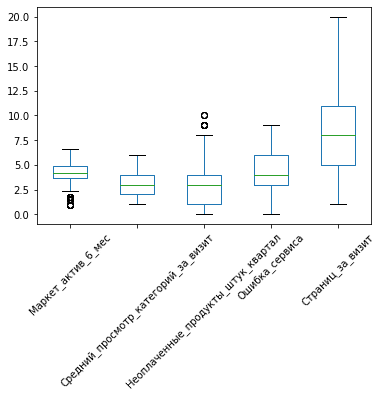

In [35]:
market_file.drop(columns = ['id' , 'Длительность','Акционные_покупки','Маркет_актив_тек_мес']).plot(kind='box', rot=45)


в параметрах Маркет_актив_6_мес пристывают выбросы в нижней части и у Средний_просмотр_категорий_за_визит тоже есть выбросы в верхней части в остальных все хорошо

<AxesSubplot:>

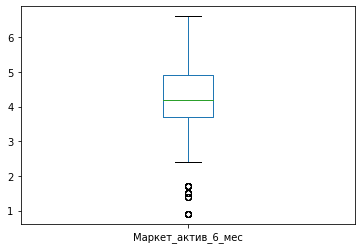

In [36]:
market_file['Маркет_актив_6_мес'].plot(kind='box')

<AxesSubplot:>

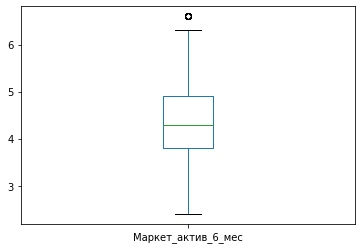

In [37]:
market_file = market_file[market_file['Маркет_актив_6_мес']>2]
market_file['Маркет_актив_6_мес'].plot(kind='box')

<AxesSubplot:>

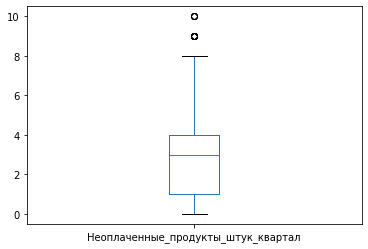

In [38]:
market_file['Неоплаченные_продукты_штук_квартал'].plot(kind='box')

<AxesSubplot:>

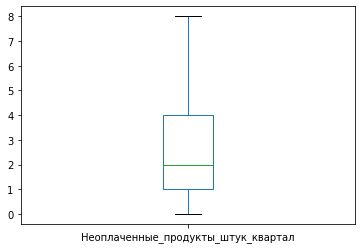

In [39]:
market_file = market_file[market_file['Неоплаченные_продукты_штук_квартал']<8.2]
market_file['Неоплаченные_продукты_штук_квартал'].plot(kind='box')

<AxesSubplot:>

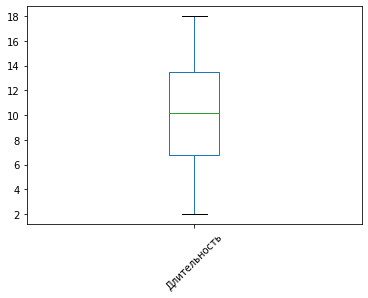

In [40]:
market_file['Длительность'].plot(kind='box', rot=45)


выбросов нет все хорошо 

<AxesSubplot:>

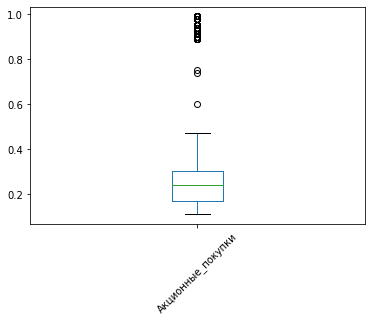

In [41]:
market_file['Акционные_покупки'].plot(kind='box', rot=45)


присутствуют выбросы сверху

In [42]:
# посмотрим сколько их и можно ли их удалить 
b =market_file['Акционные_покупки'].count()
print(b)
v =market_file[market_file['Акционные_покупки']>0.58]['Акционные_покупки'].count()
print(v)
print(f'процент выброса {(v/b)*100}')

1248
146
процент выброса 11.698717948717949


если мы выбросим то потеряем 13 процентов данных что может плохо повлиять, но также если мы их удалим то МО может чаще ошибаться из за этих данных

<AxesSubplot:>

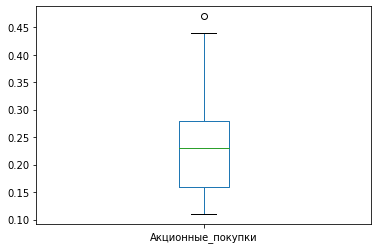

In [43]:
market_file = market_file[market_file['Акционные_покупки']<0.58]
market_file['Акционные_покупки'].plot(kind='box')

выброс остался но уменьшать еще думаю смысла нет 

<AxesSubplot:>

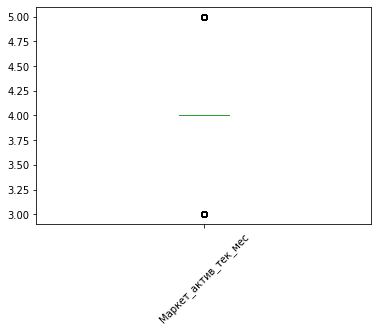

In [44]:
market_file['Маркет_актив_тек_мес'].plot(kind='box', rot=45)


явный выброс который стоит удалить, но перед этим проверить

In [45]:
market_file['Маркет_актив_тек_мес'].value_counts()

4    571
5    273
3    258
Name: Маркет_актив_тек_мес, dtype: int64

в столбце Маркет_актив_тек_мес тольео значения 4 5 3 по этому распределение с усами плохо сработоло 

<AxesSubplot:ylabel='Маркет_актив_тек_мес'>

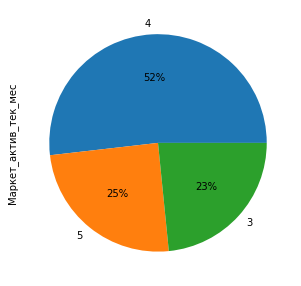

In [46]:
market_file['Маркет_актив_тек_мес'].value_counts().plot( kind = 'pie', autopct = '%1.00f%%', figsize=(5,5))

средних оценок примерно столько же как и хороших и плохих вмести взятых

Text(0.5, 1.0, 'тратта пользователем времени на сайте')

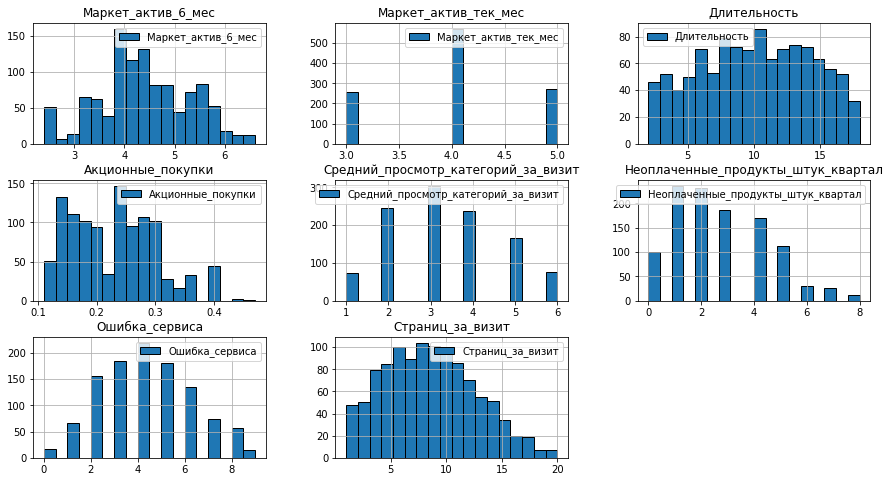

In [47]:
market_file.drop(columns ='id').hist(bins=18 ,  figsize=(15, 8), ec='black', legend=True)
plt.xlabel('минут')
plt.ylabel('пользователей')
plt.title('тратта пользователем времени на сайте')

### иследование - market_money

In [48]:
market_money.head(2)

,id,Период,Выручка
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [49]:
market_money['Период'].value_counts()

предыдущий_месяц       1297
текущий_месяц          1297
препредыдущий_месяц    1297
Name: Период, dtype: int64

<AxesSubplot:ylabel='Период'>

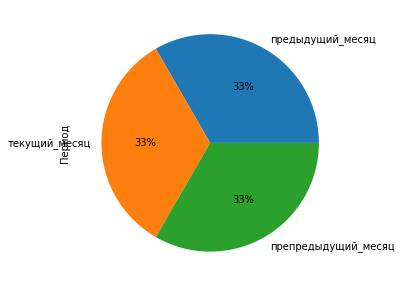

In [50]:
market_money['Период'].value_counts().plot( kind = 'pie', autopct = '%1.0f%%', figsize=(5,5))

данные по периоду распредели одинокого

In [51]:
market_money['Выручка'].describe()

count      3891.000000
mean       5033.718890
std        1768.471286
min        2758.700000
25%        4592.000000
50%        4959.000000
75%        5363.200000
max      106862.200000
Name: Выручка, dtype: float64

медиана 4959, средние 5033, минимум 2758, максимум 106862

<AxesSubplot:>

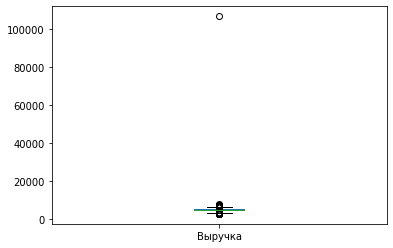

In [52]:
market_money['Выручка'].plot(kind='box')


<AxesSubplot:>

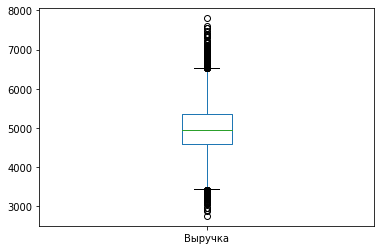

In [53]:
market_money = market_money[market_money['Выручка']<20_000]
market_money['Выручка'].plot(kind='box')

In [54]:
x =market_money[market_money['Выручка']>6400]['Выручка'].count(  )
y =market_money[market_money['Выручка']<3500]['Выручка'].count()
z =market_money['Выручка'].count()
print(f'количество выбросов {x+y}')
print(f'всего данных {z}')
print(f' процент выбросов {((x+y)/z)*100}')

количество выбросов 205
всего данных 3890
 процент выбросов 5.269922879177378


<AxesSubplot:>

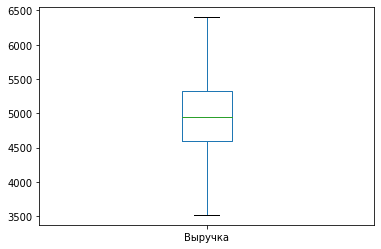

In [55]:
market_money =market_money[market_money['Выручка']<6400]
market_money =market_money[market_money['Выручка']>3500]
market_money['Выручка'].plot(kind='box')

In [56]:
market_money['Выручка'].describe()

count    3684.000000
mean     4973.958360
std       553.545896
min      3518.000000
25%      4598.000000
50%      4947.250000
75%      5324.500000
max      6399.500000
Name: Выручка, dtype: float64

 средние 4973, минимум 3518, максимум 6399.5, медиана 4947

In [57]:
spisok = ['препредыдущий_месяц', 'предыдущий_месяц' ,      
'текущий_месяц'   ]
spisok

['препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц']

In [58]:
for i in spisok:
    print(i)
    print(market_money[market_money['Период'] == i]['Выручка'].describe())
    print('-'*100)

препредыдущий_месяц
count    1297.000000
mean     4836.367772
std       333.438742
min      4098.000000
25%      4585.000000
50%      4812.000000
75%      5055.000000
max      5663.000000
Name: Выручка, dtype: float64
----------------------------------------------------------------------------------------------------
предыдущий_месяц
count    1242.000000
mean     4991.272947
std       620.734721
min      3518.000000
25%      4553.250000
50%      5028.000000
75%      5414.750000
max      6399.500000
Name: Выручка, dtype: float64
----------------------------------------------------------------------------------------------------
текущий_месяц
count    1145.000000
mean     5111.032838
std       633.985459
min      3520.300000
25%      4676.000000
50%      5109.000000
75%      5561.800000
max      6399.200000
Name: Выручка, dtype: float64
----------------------------------------------------------------------------------------------------


In [59]:
for i in spisok:
    print(i)
    c =(market_money[market_money['Период'] == i]['Выручка'].describe())
    print(f'средние {"%.2f" % c.std()}, минимум {"%.2f" % c.min()}, максимум {"%.2f" % c.max()}, мидиана {"%.2f" % c.median()}')
    print('-'*100)

препредыдущий_месяц
средние 1931.74, минимум 333.44, максимум 5663.00, мидиана 4698.50
----------------------------------------------------------------------------------------------------
предыдущий_месяц
средние 2047.86, минимум 620.73, максимум 6399.50, мидиана 4772.26
----------------------------------------------------------------------------------------------------
текущий_месяц
средние 2098.46, минимум 633.99, максимум 6399.20, мидиана 4892.50
----------------------------------------------------------------------------------------------------


в препредыдущий_месяц все показатели меньше чем во стольных группах
в текущий_месяц показатели самые большие кроме максимума он почти равен с предыдущий_месяц

<AxesSubplot:ylabel='Период'>

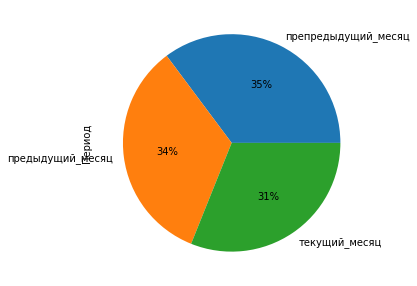

In [60]:
# посмотрим как изменилось распределение после того как удалили выбросы
market_money['Период'].value_counts().plot( kind = 'pie', autopct = '%1.0f%%', figsize=(5,5))

Text(0, 0.5, 'пользователей')

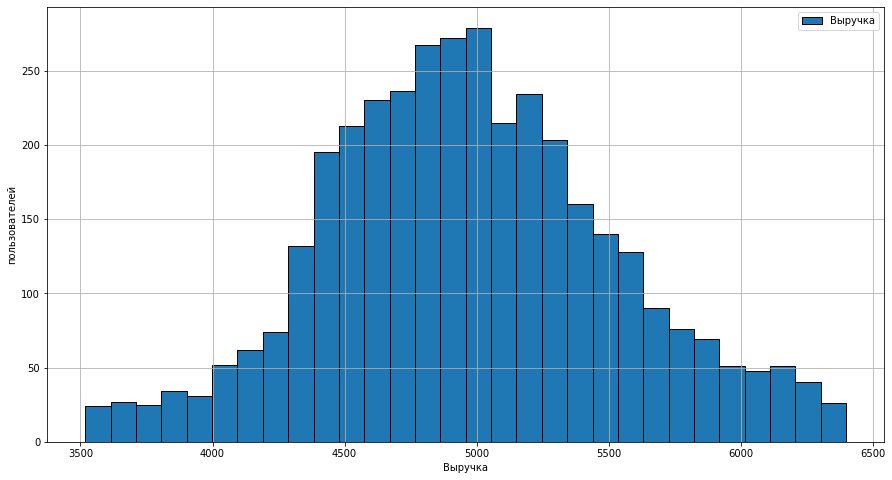

In [61]:
market_money['Выручка'].hist(bins=30 ,  figsize=(15, 8), ec='black', legend=True)
plt.xlabel('Выручка')
plt.ylabel('пользователей')


распределение хорошие в виде колокола 

## Шаг 3. Объединение таблиц

In [62]:
market_time_= (market_time.assign(n=market_time.groupby("Период").cumcount())
       .pivot_table(index="id", columns="Период", values="минут", fill_value=0))
       
market_time_['предыдущий_месяц_минут'] = market_time_['предыдущий_месяц']
market_time_['текущий_месяц_минут'] = market_time_['текущий_месяц']
market_time_ = market_time_.drop(columns=['текущий_месяц','предыдущий_месяц'])
market_time_.head(2)

Период,предыдущий_месяц_минут,текущий_месяц_минут
id,,
215349,12,10
215350,8,13


In [63]:
market_money_= (market_money.assign(n=market_money.groupby("Период").cumcount())
       .pivot_table(index="id", columns="Период", values="Выручка", fill_value=0))
       
market_money_['препредыдущий_месяц_Выручка'] = market_money_['препредыдущий_месяц']
market_money_['предыдущий_месяц_Выручка'] = market_money_['предыдущий_месяц']
market_money_['текущий_месяц_Выручка'] = market_money_['текущий_месяц']
market_money_ = market_money_.drop(columns=['текущий_месяц','предыдущий_месяц','препредыдущий_месяц'])
market_money_.head(2)

Период,препредыдущий_месяц_Выручка,предыдущий_месяц_Выручка,текущий_месяц_Выручка
id,,,
215349,4472,5216.0,4971.6
215350,4826,5457.5,5058.4


In [64]:
data = market_money_.merge(market_time_, on='id')
data = data.merge(market_file, on = 'id')
data.head(2)

,id,препредыдущий_месяц_Выручка,предыдущий_месяц_Выручка,текущий_месяц_Выручка,предыдущий_месяц_минут,текущий_месяц_минут,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215350,4826,5457.5,5058.4,8,13,Снизилась,стандартт,нет,4.9,3,8.983333,0.14,Домашний текстиль,5,2,1,5
1,215353,5124,4738.5,5388.5,10,10,Снизилась,стандартт,да,3.3,4,12.700000,0.26,Домашний текстиль,4,1,1,4


оброботав данные файлы market_time и market_money, в market_time заменил столбец 'Период' на 2 новых 'предыдущий_месяц_минут' и текущий_месяц_минут, а для market_money столбец 'Период' заменил на 3 новых 'препредыдущий_месяц_Выручка' ,'предыдущий_месяц_Выручка' и'текущий_месяц_Выручка'. Затем соидинил все 3 файла по 'id'.

## Шаг 4. Корреляционный анализ

interval columns not set, guessing: ['препредыдущий_месяц_Выручка', 'предыдущий_месяц_Выручка', 'текущий_месяц_Выручка', 'предыдущий_месяц_минут', 'текущий_месяц_минут', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит']


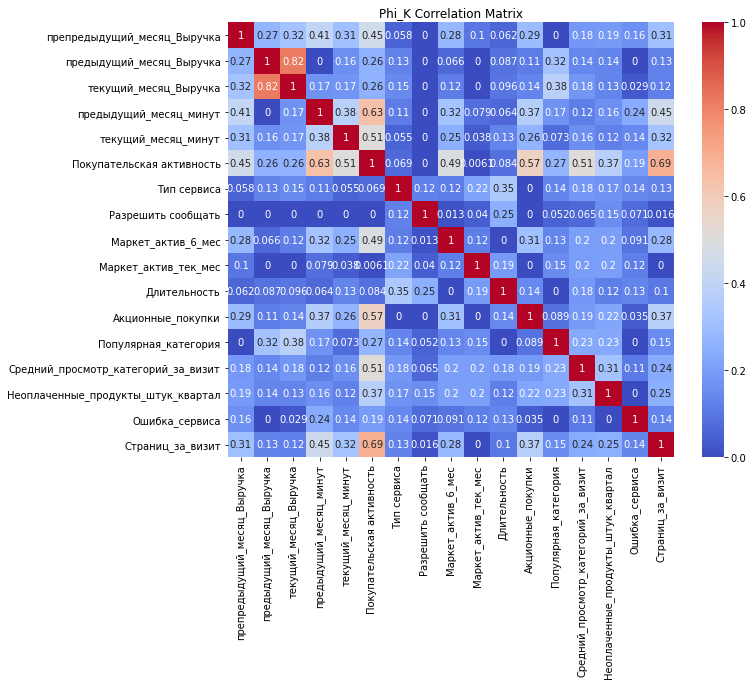

In [65]:


corr_matrix = data.drop(columns = ['id']).phik_matrix()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

из таблицы карилиации мы видим что столбец 'предыдущий_месяц_Выручка' и 'препредыдущий_месяц_Выручка' имеет прямую сильную зависимость что в дальнейшем может негативно повлиять на исследования.
также хорошая зависимость у 'Покупательская активность' и 'Страниц_за_визит'  и составляет 0.75 также 'Покупательская активность' и 'предыдущий_месяц_минут' имеет хорошую зависимость.
также есть метрика которая почти не зависит от кого либо это 'текущий_месяц_Выручка' его Корреляция максимальна это 0.14


In [66]:
data.drop(columns =['id']).corr(method = 'kendall')

,препредыдущий_месяц_Выручка,предыдущий_месяц_Выручка,текущий_месяц_Выручка,предыдущий_месяц_минут,текущий_месяц_минут,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
препредыдущий_месяц_Выручка,1.000000,0.193316,0.084185,0.209158,0.190207,0.130826,-0.038586,-0.044176,-0.162141,0.075596,-0.160318,0.057684,0.165713
предыдущий_месяц_Выручка,0.193316,1.000000,0.392956,-0.041320,-0.037888,-0.008932,-0.024563,0.008219,-0.008003,-0.046822,0.024272,0.024610,-0.038526
текущий_месяц_Выручка,0.084185,0.392956,1.000000,-0.081673,-0.080302,-0.020244,0.006425,-0.039843,0.002478,-0.033811,0.002096,0.002147,-0.027909
предыдущий_месяц_минут,0.209158,-0.041320,-0.081673,1.000000,0.211668,0.138867,0.010477,-0.096324,-0.187282,0.071358,-0.110280,0.151018,0.270157
текущий_месяц_минут,0.190207,-0.037888,-0.080302,0.211668,1.000000,0.111785,-0.047665,0.065463,-0.155980,0.162002,-0.140068,0.055657,0.149826
Маркет_актив_6_мес,0.130826,-0.008932,-0.020244,0.138867,0.111785,1.000000,0.058714,-0.053335,-0.151134,0.115271,-0.054345,0.019637,0.169292
Маркет_актив_тек_мес,-0.038586,-0.024563,0.006425,0.010477,-0.047665,0.058714,1.000000,-0.105435,0.044670,-0.008409,0.065842,0.075468,0.009448
Длительность,-0.044176,0.008219,-0.039843,-0.096324,0.065463,-0.053335,-0.105435,1.000000,0.028444,-0.057524,-0.076038,0.065428,-0.055363
Акционные_покупки,-0.162141,-0.008003,0.002478,-0.187282,-0.155980,-0.151134,0.044670,0.028444,1.000000,-0.113370,0.124156,-0.043008,-0.198235
Средний_просмотр_категорий_за_визит,0.075596,-0.046822,-0.033811,0.071358,0.162002,0.115271,-0.008409,-0.057524,-0.113370,1.000000,-0.155513,-0.001985,0.157140


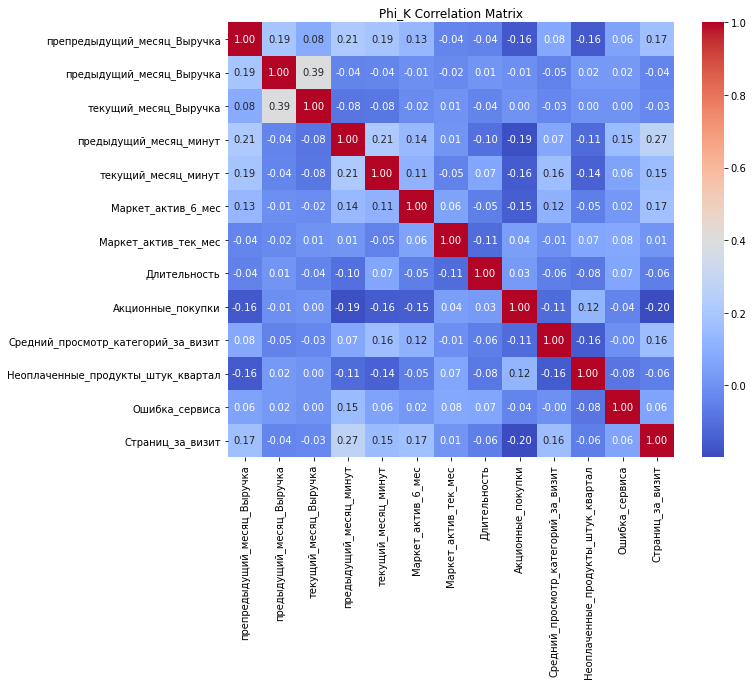

In [67]:
corr_matrix =data.drop(columns =['id']).corr(method = 'kendall')
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Phi_K Correlation Matrix')
plt.show()

на данной диаграмме также 'предыдущий_месяц_Выручка' и 'препредыдущий_месяц_Выручка' имеет корреляции 1.
картина стала темнее то что говорит о меньшей корреляции. самая высокая корреляции 'текущий_месяц_Выручка' c 'предыдущий_месяц_Выручка' и 'препредыдущий_месяц_Выручка' и равный 0.69


 ## Шаг 5. Использование пайплайнов

In [68]:
def f(data):
    if data['Тип сервиса']=='стандартт':
        return 'стандарт'
    return data['Тип сервиса']
data['Тип сервиса'] = data.apply(f , axis=1)


In [69]:
data.head(1)

,id,препредыдущий_месяц_Выручка,предыдущий_месяц_Выручка,текущий_месяц_Выручка,предыдущий_месяц_минут,текущий_месяц_минут,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215350,4826,5457.5,5058.4,8,13,Снизилась,стандарт,нет,4.9,3,8.983333,0.14,Домашний текстиль,5,2,1,5


In [70]:
data['Покупательская активность'].value_counts()

Прежний уровень    766
Снизилась          336
Name: Покупательская активность, dtype: int64

In [71]:
from sklearn.model_selection import train_test_split

X = data.drop(['Покупательская активность', 'id'], axis=1)
y = data['Покупательская активность']

RANDOM_STATE = 42
TEST_SIZE = 0.10



In [72]:
X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size = TEST_SIZE, 
                                                 random_state = RANDOM_STATE
                                                 
)
X_train.shape, X_test.shape

((991, 16), (111, 16))

In [73]:
label_encoder = LabelEncoder()
example_train = ['Прежний уровень','Снизилась']

label_encoder.fit(example_train)
test = label_encoder.transform(example_train)

y_train = label_encoder.transform(y_train)

y_test = label_encoder.transform(y_test)
pd.DataFrame(test ,example_train, columns=['LabelEncoder'])

,LabelEncoder
Прежний уровень,0
Снизилась,1


In [74]:
ohe_columns = ['Популярная_категория']
ord_columns = ['Тип сервиса','Разрешить сообщать']
num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес',
               'Длительность', 'Акционные_покупки','Средний_просмотр_категорий_за_визит',
               'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит','текущий_месяц_Выручка',
               'предыдущий_месяц_Выручка', 'препредыдущий_месяц_Выручка','предыдущий_месяц_минут', 'текущий_месяц_минут']

In [75]:
#Если в данных есть пропуски, заполним их самым часто встречающимся значением с помощью
#SimpleImputer. Назовём этот шаг simpleImputer_ohe.
#Кодируем данные с помощью OneHotEncoder. Назовём это шаг ohe.
#Объединим шаги в пайплайн и назовём его — ohe_pipe.

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

In [76]:
data['Тип сервиса'].value_counts()
    

стандарт    791
премиум     311
Name: Тип сервиса, dtype: int64

In [77]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
    
                    ['стандарт', 'премиум'],
                    ['да','нет'] 
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

In [78]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)
data_preprocessor.fit_transform(X_train)
data_preprocessor.transform(X_test)
data_preprocessor.named_transformers_['ohe'].named_steps['ohe'].get_feature_names_out(ohe_columns)

array(['Популярная_категория_Косметика и аксесуары',
       'Популярная_категория_Кухонная посуда',
       'Популярная_категория_Мелкая бытовая техника и электроника',
       'Популярная_категория_Техника для красоты и здоровья',
       'Популярная_категория_Товары для детей'], dtype=object)

In [79]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [80]:


param_grid = [ 
 
    {
     'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)], 
     'models__max_depth': range (2, 10), 
     'models__max_features': range (2, 10), 
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
 
 
    {
     'models': [KNeighborsClassifier()], 
     'models__n_neighbors': range (2, 10), 
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
 
 
    {
     'models': [LogisticRegression( 
                                     random_state=RANDOM_STATE,  
                                     solver='liblinear',  
                                     penalty='l1' 
        )],
     'models__C': range (1, 10), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(kernel='linear',probability=True,random_state=RANDOM_STATE)],
        'models__C': range(1,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]



randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)


y_test_pred = randomized_search.predict_proba(X_test)
y_test_pred = y_test_pred[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
           

так как модель ROC-AUC оценивает работу модели более обобщённо, независимо от того, какой порог классификации я выберу. Также ROC-AUC — это всеохватывающая метрика качества классификации. Она учитывает работу модели при всех возможных значениях порогов и поэтому не зависит от одного конкретного. 
и вообщем ROC-AUC используеться тогда когда необходимо оценить качество работы модели вне зависимости от выбранного порога вероятности. Метрику можно использовать в случае, когда объектов с одним значением целевого признака больше, чем с другими.
Что подходит под наш случай.


лучшей моделью стал SVC(C=2, kernel='linear', probability=True, random_state=42))])
Метрика лучшей модели на тренировочной выборке: 0.8739463199874674
Метрика ROC-AUC на тестовой выборке: 0.8465189873417721

In [81]:
randomized_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(stra...
                                                   'Маркет_актив_тек_мес',
                                                   'Длительность',
                                                   'Акционные_покупки',
                                                   'Средний_просмотр_категорий_за_визит',
                                                   'Неоплаченные_продукты_штук_квартал',
                                                   'Ошибка_сервиса',
                                                   'Страниц_за_визит',
                                                   'текущий_месяц_Выручка',
                                                   'предыдущий_месяц_Выручка',
                                                   'препредыдущий_месяц_Выручка',
                                                   'предыдущий_месяц_минут',
                                                   'текущий_месяц_минут'])])),
                ('models',
                 SVC(C=2, kernel='linear', probability=True, random_state=42))])

## Шаг 6. Анализ важности признаков

In [82]:
model = randomized_search.best_estimator_
model[1]

SVC(C=2, kernel='linear', probability=True, random_state=42)

In [83]:
model[0].get_feature_names_out()

array(['ohe__Популярная_категория_Косметика и аксесуары',
       'ohe__Популярная_категория_Кухонная посуда',
       'ohe__Популярная_категория_Мелкая бытовая техника и электроника',
       'ohe__Популярная_категория_Техника для красоты и здоровья',
       'ohe__Популярная_категория_Товары для детей', 'ord__Тип сервиса',
       'ord__Разрешить сообщать', 'num__Маркет_актив_6_мес',
       'num__Маркет_актив_тек_мес', 'num__Длительность',
       'num__Акционные_покупки',
       'num__Средний_просмотр_категорий_за_визит',
       'num__Неоплаченные_продукты_штук_квартал', 'num__Ошибка_сервиса',
       'num__Страниц_за_визит', 'num__текущий_месяц_Выручка',
       'num__предыдущий_месяц_Выручка',
       'num__препредыдущий_месяц_Выручка', 'num__предыдущий_месяц_минут',
       'num__текущий_месяц_минут'], dtype=object)

In [84]:
X_train_new = model[0].transform(X_train)                                          
#здесь используем предобратотчик лучшей модели (поэтому индекс 0 )
# X_train_new

In [85]:
explainer = shap.Explainer(model[1].predict_proba, X_train_new, feature_names=model[0].get_feature_names_out())     
# здесь участвует сама лучшая модель (поэтому индекс 1 )

In [86]:
shap_values = explainer(X_train_new)  

PermutationExplainer explainer: 992it [04:53,  3.31it/s]                         


In [87]:
shap_values.shape

(991, 20, 2)

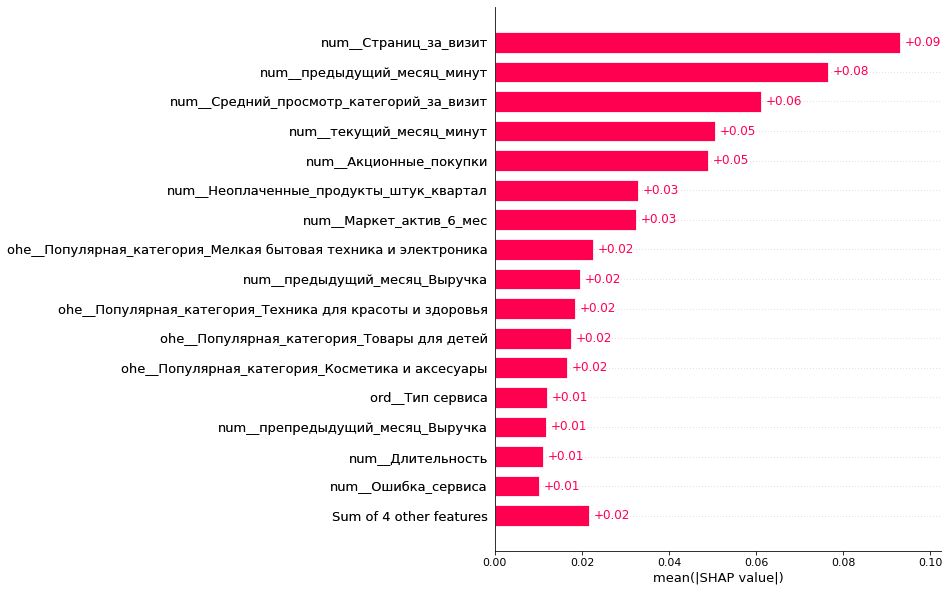

In [88]:
shap.plots.bar(shap_values[:,:,1], max_display=17) 

<div class="alert alert-info">
<b>Не знаю почему, но в шаге 88 ломается код, выводит ошибку (set_ticks() got an unexpected keyword argument 'fontsize')
и не выводит название столбцов, при этом после проверки я увидел, что он у вас хорошо сработал, не могу понять, почему у меня он не работает.</b> 
</div>

значение у ошибки сервиса очень мала так что она вообще не как не влияет на результат также товары для детей, выручка в месяц, косметика и аксессуары тоже мало влияют на результат

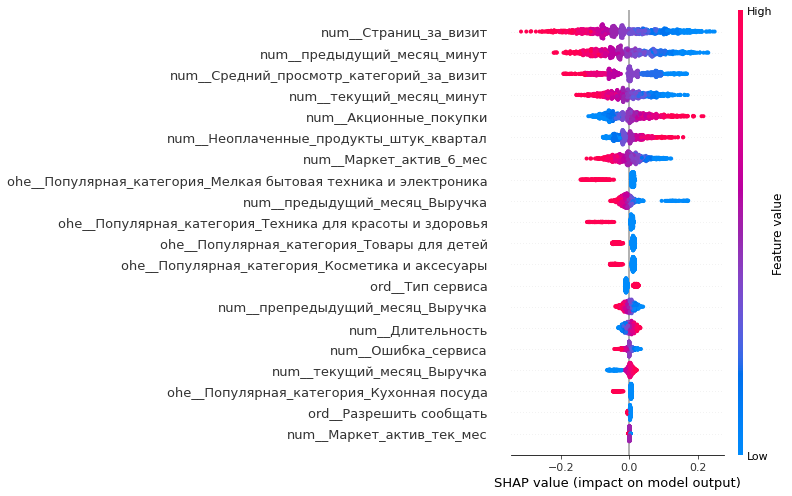

In [89]:
shap.summary_plot(shap_values[:,:,1] ,plot_size = (11,7))

такие признаки как 'ohe__Популярная_категория_Косметика и аксесуары',
       'ohe__Популярная_категория_Кухонная посуда',
       'ord__Тип сервиса',
       'ord__Разрешить сообщать',
       'num__Ошибка_сервиса', имеют меньше всего значимости, большая значимость num__предыдущий_месяц_минут, num__Страниц_за_визит, num__Средний_просмотр_категорий_за_визит

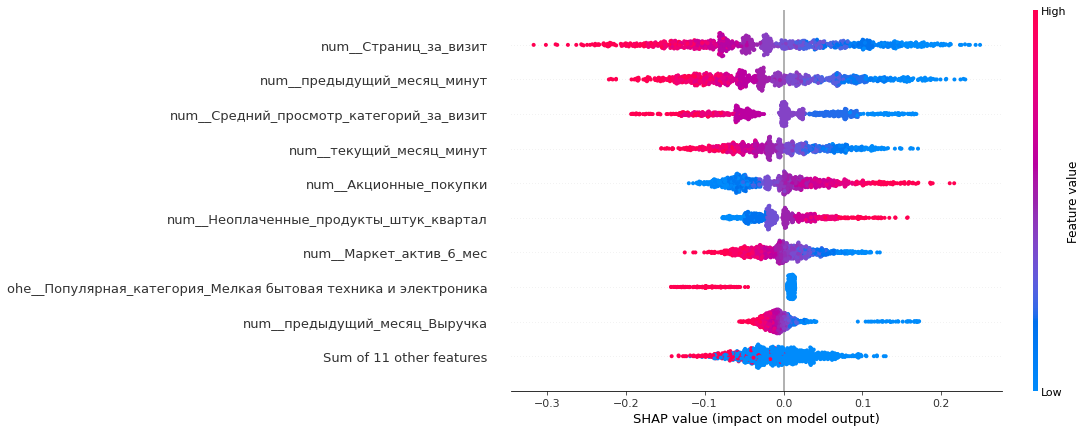

In [90]:
shap.plots.beeswarm(shap_values[:,:,1] ,plot_size = (11,7))


из графика можно увидеть что num__предыдущий_месяц_минут, num__Страниц_за_визит, num__Средний_просмотр_категорий_за_визит, num__текущий_месяц_минут, num__Маркет_актив_6_мес, num__предыдущий_месяц_Выручка Здесь — чем больше значения признаков — тем меньше SHAP‑значения.
Например, в случае с признаком num__препредыдущий_месяц_Выручка, num__Акционные_покупки, num__Неоплаченные_продукты_штук_квартал видно, что SHAP‑значения растут по мере роста значения признака. 


<font color='red'><b>вывод по шагу 6 анализу важности  признаков</b></font>
эти наблюдения можно использовать так:
- убрать мало значимые значения из за которых не пострадает модель при этом облегчит и возможно ускорит работу и анализ, облегчит просмотр данных
- возможность по главным более значимым признакам сразу искать про дальнейшие события
- по важным признакам понять что надо менять что увеличивать, уменьшать
 

## Шаг 7. Сегментация покупателей

In [91]:
data.head()

,id,препредыдущий_месяц_Выручка,предыдущий_месяц_Выручка,текущий_месяц_Выручка,предыдущий_месяц_минут,текущий_месяц_минут,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215350,4826,5457.5,5058.4,8,13,Снизилась,стандарт,нет,4.9,3,8.983333,0.14,Домашний текстиль,5,2,1,5
1,215353,5124,4738.5,5388.5,10,10,Снизилась,стандарт,да,3.3,4,12.700000,0.26,Домашний текстиль,4,1,1,4
2,215354,4503,5685.0,5869.6,11,12,Снизилась,стандарт,да,5.1,3,7.183333,0.23,Косметика и аксесуары,2,3,7,2
3,215355,4749,0.0,3772.6,12,10,Снизилась,стандарт,нет,4.7,4,4.733333,0.17,Товары для детей,5,1,6,4
4,215356,4433,4146.5,4566.4,6,7,Снизилась,стандарт,да,4.2,4,3.200000,0.14,Косметика и аксесуары,2,2,1,3


In [92]:
data['прибыль']=data['препредыдущий_месяц_Выручка']+data['предыдущий_месяц_Выручка']+data['текущий_месяц_Выручка']
data.head()

,id,препредыдущий_месяц_Выручка,предыдущий_месяц_Выручка,текущий_месяц_Выручка,предыдущий_месяц_минут,текущий_месяц_минут,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,прибыль
0,215350,4826,5457.5,5058.4,8,13,Снизилась,стандарт,нет,4.9,3,8.983333,0.14,Домашний текстиль,5,2,1,5,15341.9
1,215353,5124,4738.5,5388.5,10,10,Снизилась,стандарт,да,3.3,4,12.700000,0.26,Домашний текстиль,4,1,1,4,15251.0
2,215354,4503,5685.0,5869.6,11,12,Снизилась,стандарт,да,5.1,3,7.183333,0.23,Косметика и аксесуары,2,3,7,2,16057.6
3,215355,4749,0.0,3772.6,12,10,Снизилась,стандарт,нет,4.7,4,4.733333,0.17,Товары для детей,5,1,6,4,8521.6
4,215356,4433,4146.5,4566.4,6,7,Снизилась,стандарт,да,4.2,4,3.200000,0.14,Косметика и аксесуары,2,2,1,3,13145.9


In [93]:
data_proba=data.drop(['прибыль','Покупательская активность','id'],axis=1)
data_proba = randomized_search.predict_proba(data_proba)
data_proba = data_proba[:,1]
data_proba

array([0.35691866, 0.77983238, 0.70351195, ..., 0.11857886, 0.28281705,
       0.08729023])

In [94]:
data['вероятность_снижения'] = data_proba
data.head()

,id,препредыдущий_месяц_Выручка,предыдущий_месяц_Выручка,текущий_месяц_Выручка,предыдущий_месяц_минут,текущий_месяц_минут,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,прибыль,вероятность_снижения
0,215350,4826,5457.5,5058.4,8,13,Снизилась,стандарт,нет,4.9,3,8.983333,0.14,Домашний текстиль,5,2,1,5,15341.9,0.356919
1,215353,5124,4738.5,5388.5,10,10,Снизилась,стандарт,да,3.3,4,12.700000,0.26,Домашний текстиль,4,1,1,4,15251.0,0.779832
2,215354,4503,5685.0,5869.6,11,12,Снизилась,стандарт,да,5.1,3,7.183333,0.23,Косметика и аксесуары,2,3,7,2,16057.6,0.703512
3,215355,4749,0.0,3772.6,12,10,Снизилась,стандарт,нет,4.7,4,4.733333,0.17,Товары для детей,5,1,6,4,8521.6,0.406517
4,215356,4433,4146.5,4566.4,6,7,Снизилась,стандарт,да,4.2,4,3.200000,0.14,Косметика и аксесуары,2,2,1,3,13145.9,0.884628


In [95]:
data_suum = data[data['вероятность_снижения']>0.80 ]
data_suum = data_suum[data_suum['прибыль']>12000]
data_suum.head()

,id,препредыдущий_месяц_Выручка,предыдущий_месяц_Выручка,текущий_месяц_Выручка,предыдущий_месяц_минут,текущий_месяц_минут,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,прибыль,вероятность_снижения
4,215356,4433,4146.5,4566.4,6,7,Снизилась,стандарт,да,4.2,4,3.200000,0.14,Косметика и аксесуары,2,2,1,3,13145.9,0.884628
6,215360,5555,5304.5,5834.9,9,6,Снизилась,премиум,да,3.9,3,10.383333,0.35,Кухонная посуда,3,1,4,7,16694.4,0.819656
10,215367,4668,5164.5,5493.4,8,7,Снизилась,премиум,да,4.2,4,9.683333,0.40,Товары для детей,5,1,4,1,15325.9,0.906861
11,215368,4536,5823.0,5591.6,11,9,Снизилась,премиум,да,3.8,5,13.816667,0.24,Техника для красоты и здоровья,2,2,6,1,15950.6,0.843235
12,215369,4931,3593.0,3842.6,8,9,Снизилась,стандарт,нет,2.7,4,10.116667,0.21,Товары для детей,2,2,3,4,12366.6,0.899183


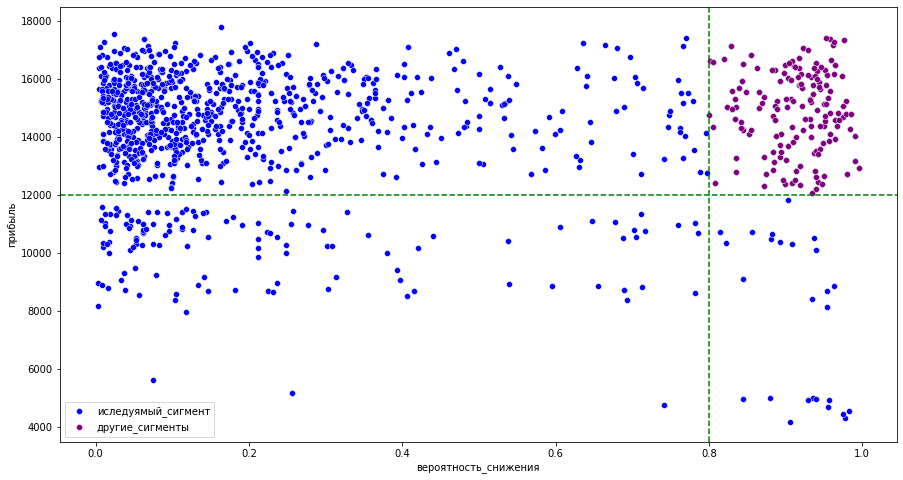

In [96]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=data, x='вероятность_снижения', y='прибыль', label='иследуямый_сигмент', color='blue')
sns.scatterplot(data=data_suum, x='вероятность_снижения', y='прибыль', label='другие_сигменты', color='purple')
plt.legend()
plt.axvline(x=0.8, color = 'green', linestyle='--')
plt.axhline(y=12000, color='green', linestyle='--')
plt.show()


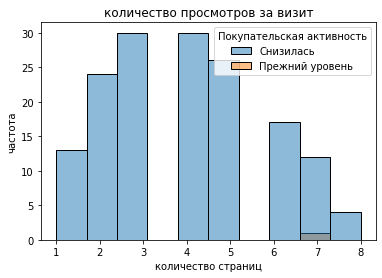

In [97]:
sns.histplot(data_suum, x='Страниц_за_визит', hue='Покупательская активность')
plt.title('количество просмотров за визит')
plt.xlabel('количество страниц')
plt.ylabel('частота')
plt.show()

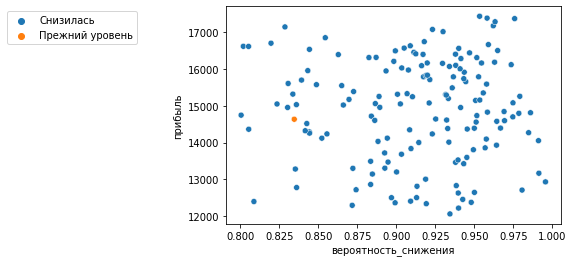

In [98]:
sns.scatterplot(x='вероятность_снижения', y='прибыль',
                    hue="Покупательская активность"  ,
                    
                    data=data_suum)
plt.legend(bbox_to_anchor=(-0.25, 1))

этот сегмент нам интересен, и нам надо понять почему клиенты с хорошим доходом и большая вероятность ухода.

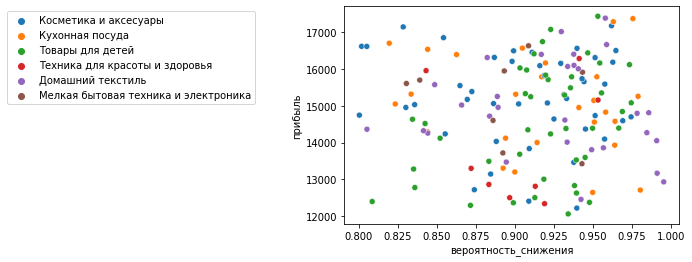

In [99]:
sns.scatterplot(x='вероятность_снижения',
                y='прибыль',
                hue="Популярная_категория",
                data=data_suum)
plt.legend(bbox_to_anchor=(-0.25, 1))

<AxesSubplot:ylabel='Популярная_категория'>

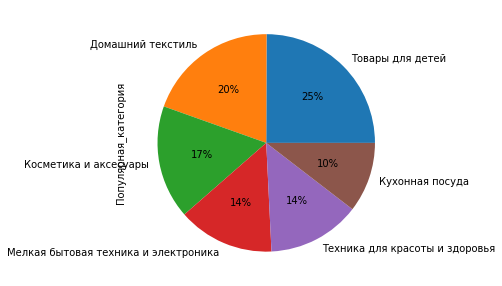

In [100]:
data['Популярная_категория'].value_counts().plot( kind = 'pie', autopct = '%1.0f%%', figsize=(5,5))

<AxesSubplot:ylabel='Популярная_категория'>

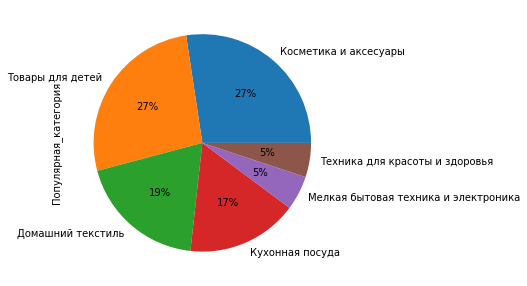

In [101]:
data_suum['Популярная_категория'].value_counts().plot( kind = 'pie',
                                                      autopct = '%1.0f%%',
                                                      figsize=(5,5))

56% людей посещающие косметику и аксессуары и товары для детей, снижаться активность можно была бы предложить что уходят из за этих категорий но они в общем соизволяют 45% посещения всех клиентов это теория отпадает

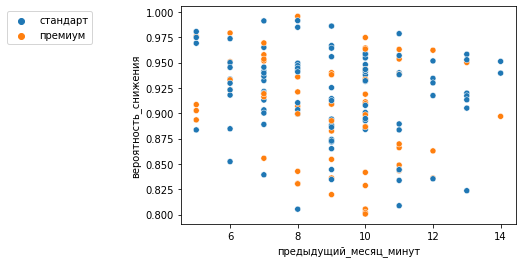

In [102]:
sns.scatterplot(y='вероятность_снижения',
                x='предыдущий_месяц_минут',
                hue='Тип сервиса',
                data=data_suum)
plt.legend(bbox_to_anchor=(-0.25, 1))

Text(0.5, 0, 'минут')

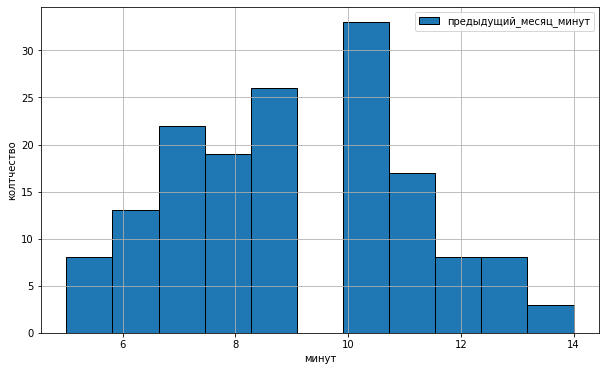

In [103]:
data_suum['предыдущий_месяц_минут'].hist(bins=11 ,  figsize=(10, 6), ec='black', legend=True)
plt.ylabel('колтчество')
plt.xlabel('минут')


Text(0.5, 0, 'минут')

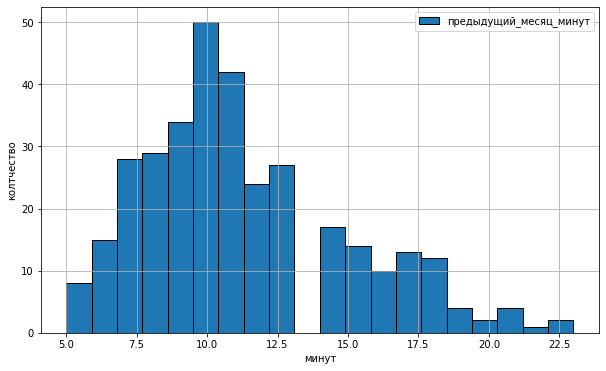

In [104]:
data[data["Покупательская активность"] == 'Снизилась']['предыдущий_месяц_минут'].hist(bins=20 ,  figsize=(10, 6), ec='black', legend=True)
plt.ylabel('колтчество')
plt.xlabel('минут')


можно увидеть четкое разделение большая часть клиентов со снижением активности находить по времени до 12.5 минут 

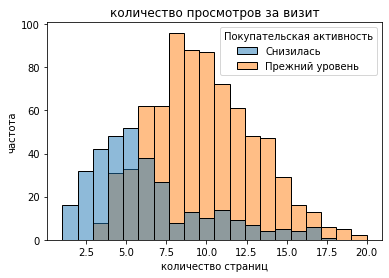

In [105]:
sns.histplot(data, x='Страниц_за_визит', hue='Покупательская активность')
plt.title('количество просмотров за визит')
plt.xlabel('количество страниц')
plt.ylabel('частота')
plt.show()

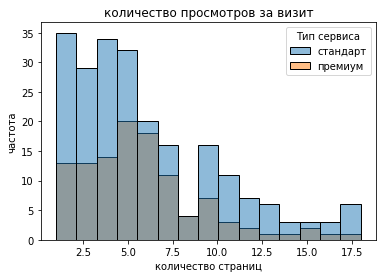

In [106]:
sns.histplot(data[data['Покупательская активность'] == 'Снизилась'], x='Страниц_за_визит', hue='Тип сервиса')
plt.title('количество просмотров за визит')
plt.xlabel('количество страниц')
plt.ylabel('частота')
plt.show()

из графика видно что чем больше просмотров тем меньше соотношение со стандартным и премиум.

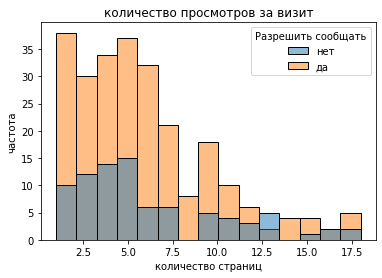

In [107]:
sns.histplot(data[data['Покупательская активность'] == 'Снизилась'], x='Страниц_за_визит', hue='Разрешить сообщать')
plt.title('количество просмотров за визит')
plt.xlabel('количество страниц')
plt.ylabel('частота')
plt.show()

при том что покупательная способность снизилась им приходили сообщения от приложения так что не в сообщениях дело

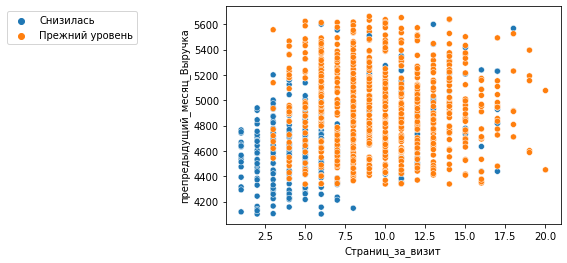

In [108]:
sns.scatterplot(x="Страниц_за_визит",
                    y="препредыдущий_месяц_Выручка",
                    hue="Покупательская активность"  ,
                    
                    data=data)
plt.legend(bbox_to_anchor=(-0.25, 1))

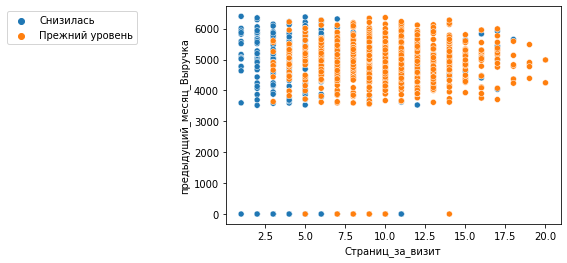

In [109]:
sns.scatterplot(x="Страниц_за_визит",
                y="предыдущий_месяц_Выручка",
                hue="Покупательская активность"  ,
                data=data)
plt.legend(bbox_to_anchor=(-0.25, 1))

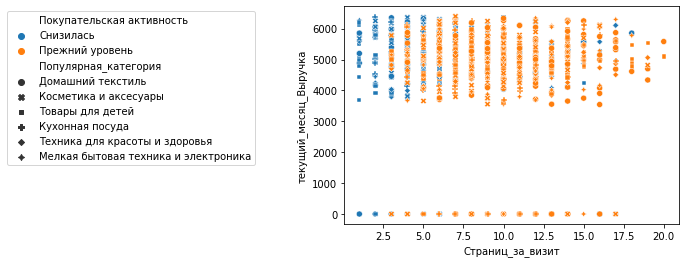

In [110]:
sns.scatterplot(x="Страниц_за_визит",
                y="текущий_месяц_Выручка",
                style="Популярная_категория",
                hue="Покупательская активность",
                data=data)
plt.legend(bbox_to_anchor=(-0.25, 1))

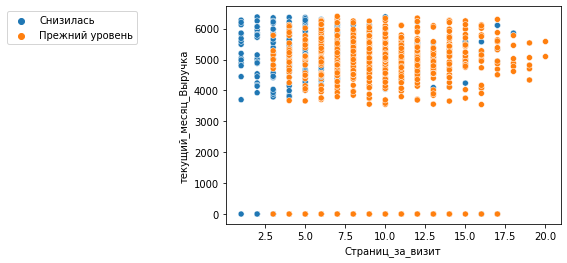

In [111]:
sns.scatterplot(x="Страниц_за_визит",
                y="текущий_месяц_Выручка",
                hue="Покупательская активность"  ,
                data=data)
plt.legend(bbox_to_anchor=(-0.25, 1))

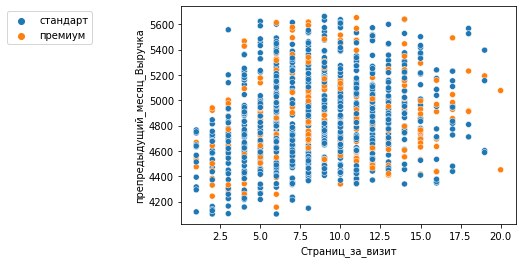

In [112]:
sns.scatterplot(x="Страниц_за_визит",
                    y="препредыдущий_месяц_Выручка",
                    hue="Тип сервиса",
                    data=data)
plt.legend(bbox_to_anchor=(-0.25, 1))

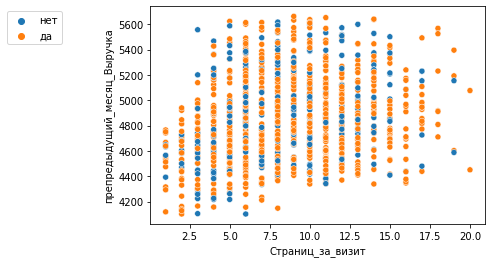

In [113]:
sns.scatterplot(x="Страниц_за_визит",
                    y="препредыдущий_месяц_Выручка",
                    hue='Разрешить сообщать',
                    data=data)
plt.legend(bbox_to_anchor=(-0.25, 1))

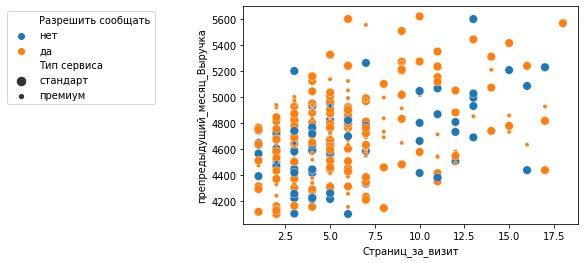

In [114]:
sns.scatterplot(x="Страниц_за_визит",
                y="препредыдущий_месяц_Выручка",
                hue='Разрешить сообщать',
                
                size = 'Тип сервиса',
                data=data[data['Покупательская активность'] == 'Снизилась'])
plt.legend(bbox_to_anchor=(-0.25, 1))

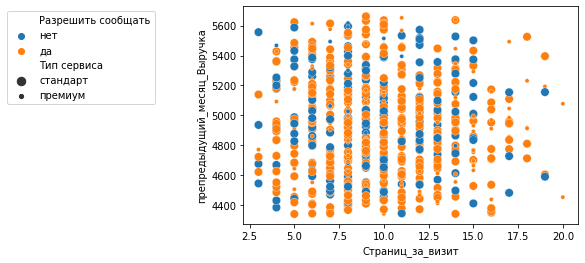

In [115]:
sns.scatterplot(x="Страниц_за_визит",
                y="препредыдущий_месяц_Выручка",
                hue='Разрешить сообщать',
                
                size = 'Тип сервиса',
                data=data[data['Покупательская активность'] != 'Снизилась'])
plt.legend(bbox_to_anchor=(-0.25, 1))

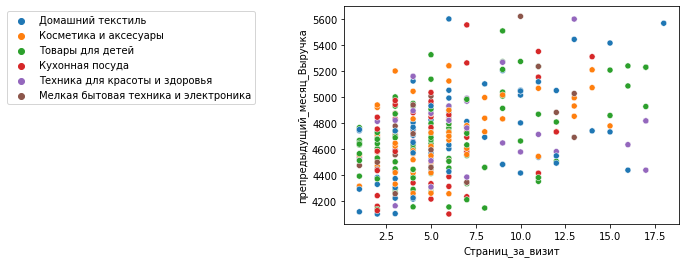

In [116]:
sns.scatterplot(x="Страниц_за_визит",
                y="препредыдущий_месяц_Выручка",
                hue='Популярная_категория',
                
                
                data=data[data['Покупательская активность'] == 'Снизилась'])
plt.legend(bbox_to_anchor=(-0.25, 1))

<AxesSubplot:ylabel='Популярная_категория'>

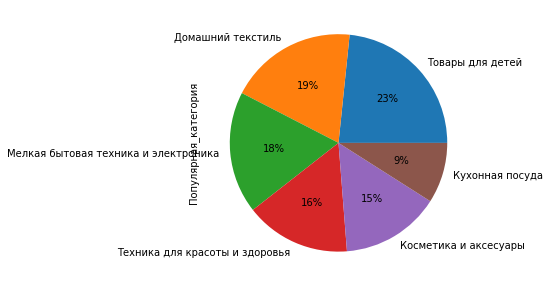

In [117]:
data[data['Покупательская активность'] != 'Снизилась']['Популярная_категория'].value_counts().plot( kind = 'pie', autopct = '%1.0f%%', figsize=(5,5))

In [118]:
data[data['Покупательская активность'] == 'Снизилась']['Популярная_категория'].value_counts()

Товары для детей                        96
Косметика и аксесуары                   73
Домашний текстиль                       70
Кухонная посуда                         46
Техника для красоты и здоровья          32
Мелкая бытовая техника и электроника    19
Name: Популярная_категория, dtype: int64

In [119]:
data[data['Покупательская активность'] != 'Снизилась']['Популярная_категория'].value_counts()

Товары для детей                        179
Домашний текстиль                       146
Мелкая бытовая техника и электроника    139
Техника для красоты и здоровья          120
Косметика и аксесуары                   113
Кухонная посуда                          69
Name: Популярная_категория, dtype: int64

In [120]:
data['Популярная_категория'].value_counts()

Товары для детей                        275
Домашний текстиль                       216
Косметика и аксесуары                   186
Мелкая бытовая техника и электроника    158
Техника для красоты и здоровья          152
Кухонная посуда                         115
Name: Популярная_категория, dtype: int64

Из данного анализа нельзя сказать, что какой-то изменяемый фактор влияет на активность пользователей, в большей части зависит от количества просмотренных страниц, что, к сожалению, нельзя улучшить каким-либо образом, зависимости между типом сервиса как таковой нет, только то, что люди с подпиской составляют минимум, также нет какой-то сильно выраженной категории, которую стоило или улучшить, или убрать. 

## Шаг 8 Общий вывод

сначала проверив все файлы и проведя с ними подготовительные операции. В дальнейшем мы сделали паплейн который на входных данных дал нам лучшую модель МО для прогноза Покупательской активности. после провели анализ важности признаков что показало такие данные как предыдущий месяц минут, страниц за визит, средний просмотр за визит сильно влияет на покупателя и действует в обратную сторону если было много посещений то потом будет меньше, а не оплаченный товар наоборот чем его больше то активность возрастала. 

Также на активность может влиять географическое расположение покупателя и месяц года, все-таки в Новый год покупок делают больше, и, наверное, активность после него падает, а летом количество покупателей сдвигается в другой сегмент, так же, как и к сентябрю количество покупок увеличивается, также возможны региональные праздники, так что можно предположить, что большинство, у кого снизилась активность, могли находиться географически в одном месте или даже в одном возрастном сегменте.
 Мои рассуждения могут быть и неверны, но было просмотреть и эти факторы, может, они и верны, также наблюдения за 3 месяца малы, и в какой период, наверное, все-таки к Новому году активность пользователей больше и быстро растет, а после НГ падает. 